In [0]:
import tensorflow as tf # import tensorflow
from tensorflow.contrib.tensorboard.plugins import projector # used to visualize data
import datetime 
import numpy as np
from scipy.misc import bytescale
import matplotlib.pyplot as plt # used to plot 

In [0]:
!pip3 install -q tflearn # install tflearn
import tflearn

In [3]:
# load in mnist dataset through tflearn
import tflearn.datasets.mnist as mnist # import dataset
X, Y, testX, testY = mnist.load_data(one_hot=True) # load in training and testing sets

Succesfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting mnist/train-images-idx3-ubyte.gz
Succesfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting mnist/train-labels-idx1-ubyte.gz
Succesfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist/t10k-images-idx3-ubyte.gz
Succesfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [4]:
# print the shapes of training and testing sets
print(X.shape, Y.shape, testX.shape, testY.shape)

(55000, 784) (55000, 10) (10000, 784) (10000, 10)


In [5]:
print(Y[:10, ...]) # print the first 10 labels

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [0]:
# change the background to white and number to black
X, testX = 1. - X, 1. - testX

In [0]:
def montage(x, return_grid=False):
  '''Function that takes in a 2D tensor of images x
     with shape n x d, where n is the number of images
     and d is the number of pixels, and puts them 
     together as a single image.'''
  
  num = int(np.sqrt(x.shape[0]))
  m = int(np.ceil(np.sqrt(x.shape[1])))
  n = m
  grid = np.zeros([num*m, num*n])
  
  for i in range(num):
    for j in range(num):
      grid[i*m:i*m+m, j*n:j*n+n] = bytescale(x[i*num+j, ...].reshape([28, 28]))
      
  if return_grid:
    return grid
      
  fig = plt.figure(figsize=(15, 15))
  a1 = fig.add_subplot(111)
  a1.imshow(grid)
  a1.grid(False)
  plt.show()
  return 

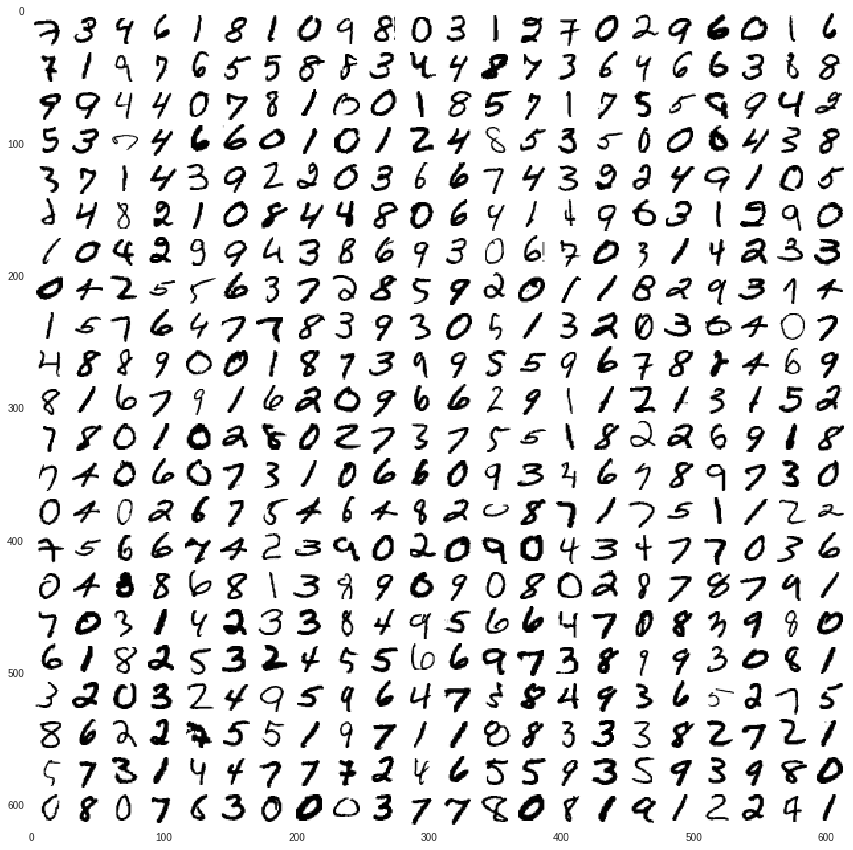

In [8]:
montage(X[:500, :])

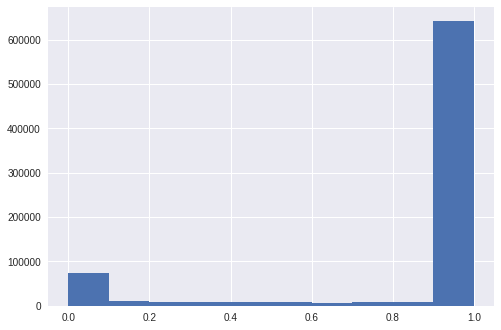

In [9]:
# plot a histogram of the values of the first 1000 images
plt.hist(X[:1000, :].flatten(), bins=10)
plt.show()

In [0]:
mean = np.mean(X, 0) # take the mean of each pixel in the training set
X -= mean  # center pixel values of training set around 0

In [0]:
# center pixel values of test set around 0
testX -= mean

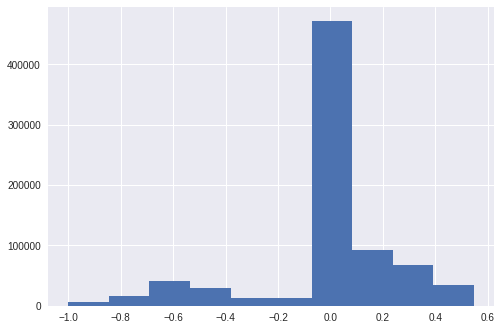

In [12]:
# plot a histogram of the values in the normalized training set
plt.hist(X[:1000, :].flatten(), bins=10)
plt.show()

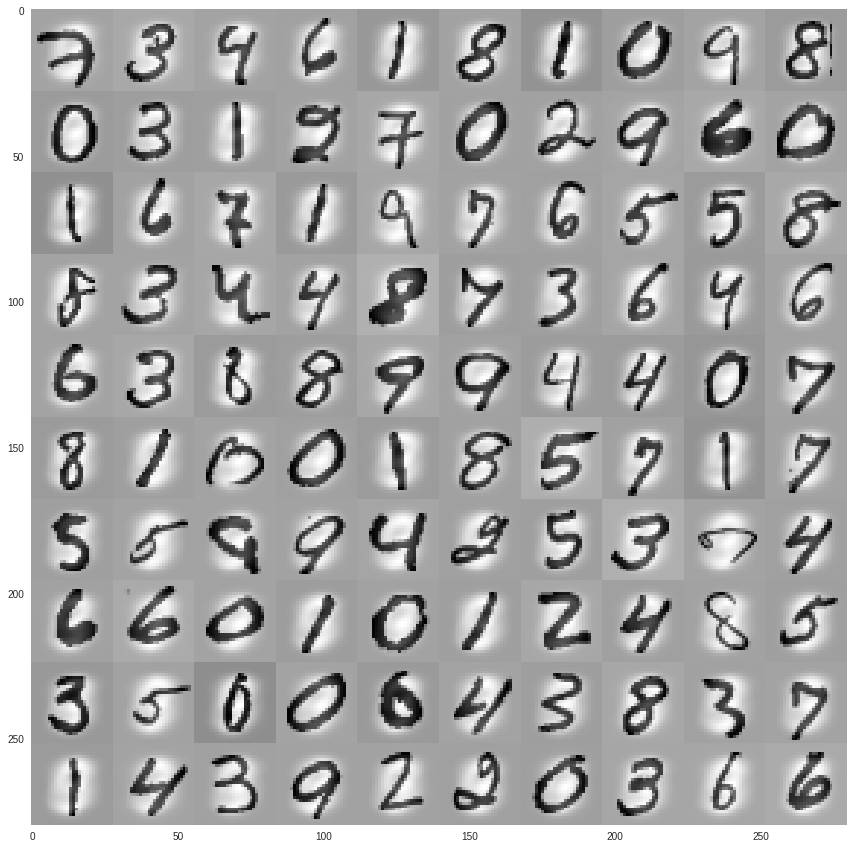

In [13]:
montage(X[:100, :])

In [0]:
def install_tensorboard_dep():
  '''This function installs the necessary software to get tensorboard
     working on colaboratory.'''
  
  if 'ngrok-stable-linux-amd64.zip' not in os.listdir(os.getcwd()):
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip
    os.system('n')
    
  return

In [0]:
def start_tensorboard():
  '''This function starts tensorboard so you can visualize training.'''
  
  LOG_DIR = '/tmp/tflearn_logs'
  get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))
  get_ipython().system_raw('./ngrok http 6006 &')
  ! curl -s http://localhost:4040/api/tunnels | python3 -c \
  "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
  
  return

In [0]:
def viz_mnist_embedding(tensor, images, labels):
  '''Takes in a TF variable tensor, along with images and their 
     corresponding labels and sets up the projector to 
     visualize the data space.'''
  
  tb_dir = '/tmp/tflearn_logs'
  sess = tf.Session()
  sess.run(tensor.initializer)
  summary_writer = tf.summary.FileWriter(tb_dir)
  config = projector.ProjectorConfig()
  embedding = config.embeddings.add()
  embedding.tensor_name = tensor.name
  embedding.metadata_path = os.path.join(tb_dir, 'metadata.tsv')
  embedding.sprite.image_path = os.path.join(tb_dir, 'mnistdigits.png') 
  embedding.sprite.single_image_dim.extend([28,28])
  projector.visualize_embeddings(summary_writer, config)
  saver = tf.train.Saver([tensor])
  saver.save(sess, os.path.join(tb_dir, 'mnist_fc.ckpt'), 1)
  
  image_grid = montage(images, True)
  plt.imsave(os.path.join(tb_dir, 'mnistdigits.png'), image_grid, cmap='gray')
  
  with open(os.path.join(tb_dir, 'metadata.tsv'),'w') as f:
    f.write("Index\tLabel\n")
    for index,label in enumerate(labels):
      f.write("%d\t%d\n" % (index,label))
  f.close()

  return

In [0]:
tf.reset_default_graph()  # reset the graph if running more than once

In [0]:
# make the input layer of the network
input_layer = tflearn.input_data(shape=[None, 784])

In [0]:
# make a variable for the visualization
emb = tf.Variable(X[:5000, :], name='input_images')

In [0]:
# first hidden layer
hidden1 = tflearn.fully_connected(input_layer, 500, activation='tanh', name='fc1')

# dropout for first hidden layer --- keep 70% 
hidden1 = tflearn.dropout(hidden1, 0.7)

# make the second hidden layer
hidden2 = tflearn.fully_connected(hidden1, 500, activation='tanh', name='fc2')

# dropout for second layer --- keep 70% of values
hidden2 = tflearn.dropout(hidden2, 0.7)

# make the third hidden layer
hidden3 = tflearn.fully_connected(hidden2, 500, activation='tanh', name='fc3')

# dropout for third layer --- keep 70% of values
hidden3 = tflearn.dropout(hidden3, 0.7)

# make the output layer 
output = tflearn.fully_connected(hidden3, 10, activation='softmax', name='output_layer')

In [0]:
# describe the optimizer --- learning rate between 1e-5 and .1
sgd = tflearn.SGD(learning_rate=0.1)

In [21]:
# describe how to update weights
network = tflearn.regression(output, optimizer=sgd, loss='categorical_crossentropy')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
import os

In [23]:
tensorboard_name = 'mnist_fc_tflearn'  # name for tensorboard run
viz_mnist_embedding(emb, X[:5000, :], np.argmax(Y[:5000, :], 1))

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


In [24]:
install_tensorboard_dep() # install tensorboard dependencies


Redirecting output to ‘wget-log’.
Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [25]:
start_tensorboard()  # start tensorboard to visualize training/model/etc.

http://aa461b00.ngrok.io


In [0]:
# build the model based on architecture/parameters described above
model = tflearn.DNN(network, tensorboard_verbose=3) 

In [27]:
model.fit(X,  # training data
          Y,  # training labels
          n_epoch=10,  # number of times to go through dataset
          validation_set=(testX, testY),  # validation dataset/labels
          batch_size=100,  # number of practice images to look at at one time
          snapshot_step=200,  # how often to test of validation
          show_metric=True,
          run_id='mnist_fc_3layers')  # what to show model under in tensorboard

Training Step: 3586  | total loss: 0.25141 | time: 70.361s
| SGD | epoch: 007 | loss: 0.25141 - acc: 0.9290 -- iter: 28600/55000


KeyboardInterrupt: ignored

In [28]:
model.save('mnist_fc_3layers_model')  # save the trained model

INFO:tensorflow:/content/mnist_fc_3layers_model is not in all_model_checkpoint_paths. Manually adding it.


In [0]:
# load in trained model
from tensorflow.python import pywrap_tensorflow
reader = pywrap_tensorflow.NewCheckpointReader('mnist_fc_3layers_model')
model_vars = reader.get_variable_to_shape_map() # get weights of trained model

In [31]:
print(model_vars) # print out model variables

{'input_images': [5000, 784], 'fc3/b': [500], 'val_acc': [], 'output_layer/W': [500, 10], 'fc3/W': [500, 500], 'fc2/b': [500], 'fc2/W': [500, 500], 'Crossentropy/Mean/moving_avg': [], 'Training_step': [], 'Accuracy/Mean/moving_avg': [], 'val_loss': [], 'Global_Step': [], 'output_layer/b': [10], 'is_training': [], 'fc1/b': [500], 'fc1/W': [784, 500]}


In [0]:
# get weights of first hidden layer
hidden1_w = reader.get_tensor('fc1/W')

In [33]:
# print shape of first hidden layer's weights
print(hidden1_w.shape)

(784, 500)


In [0]:
hidden1_w = hidden1_w.T  # transpose hidden weights to go into montage function

In [35]:
print(hidden1_w.shape)

(500, 784)


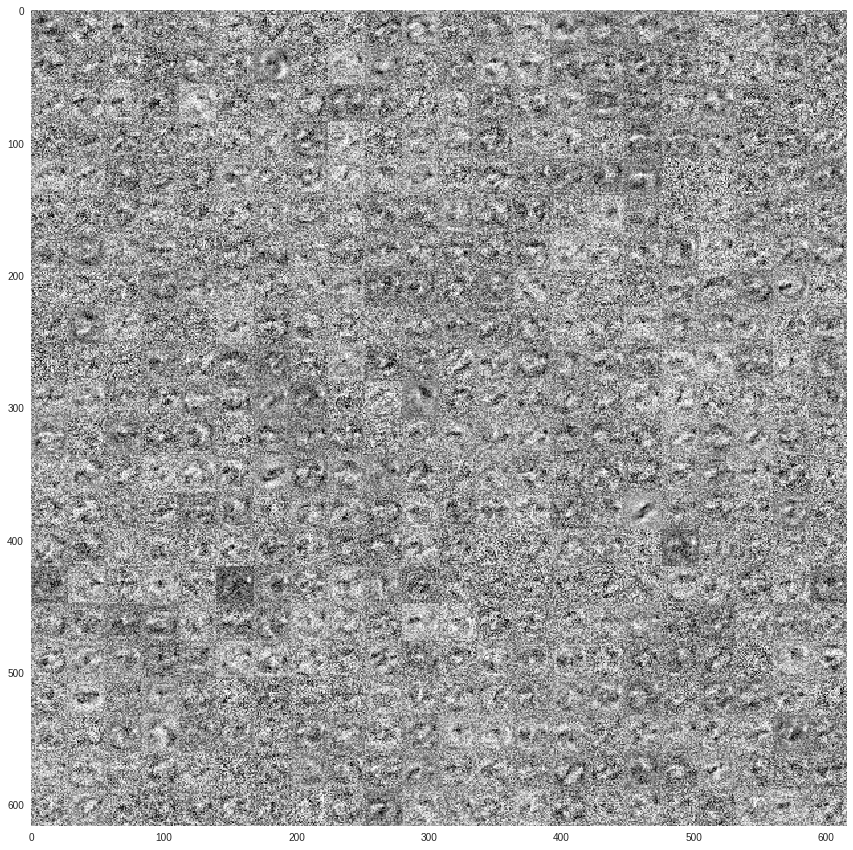

In [38]:
montage(hidden1_w)  # view weights of first hidden layer